<a href="https://colab.research.google.com/github/badbloody/diploma2023/blob/main/my_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connecting to Google Drive where we can save the results

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Importing the needed libraries here:

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import random
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import shutil
from glob import glob

import numpy as np
import multiprocessing
import copy
from tqdm import tqdm
from collections import defaultdict

import torch.utils.data.distributed
import time
from pprint import pprint
display = pprint

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining helper functions for processing images and calculating the standard deviation

In [5]:
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]
tensor_normalizer = transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std)
epsilon = 1e-5

def preprocess_image(image, target_width=None):
    """ input PIL.Image, return a normalized four-dimensional tensor """
    if target_width:
        t = transforms.Compose([
            transforms.Resize(target_width),
            transforms.CenterCrop(target_width),
            transforms.ToTensor(),
            tensor_normalizer,
        ])
    else:
        t = transforms.Compose([
            transforms.ToTensor(),
            tensor_normalizer,
        ])
    return t(image).unsqueeze(0)


def image_to_tensor(image, target_width=None):
    """ input OpenCV image, range 0~255, BGR order, return a normalized four-dimensional tensor """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    return preprocess_image(image, target_width)


def read_image(path, target_width=None):
    image = Image.open(path)
    return preprocess_image(image, target_width)


def recover_image(tensor):
    """ input a four-dimensional tensor on the GPU, return a three-dimensional numpy matrix in the range of 0~255, RGB orde r"""
    image = tensor.detach().cpu().numpy()
    image = image * np.array(cnn_normalization_std).reshape((1, 3, 1, 1)) + \
    np.array(cnn_normalization_mean).reshape((1, 3, 1, 1))
    return (image.transpose(0, 2, 3, 1) * 255.).clip(0, 255).astype(np.uint8)[0]


def recover_tensor(tensor):
    m = torch.tensor(cnn_normalization_mean).view(1, 3, 1, 1).to(tensor.device)
    s = torch.tensor(cnn_normalization_std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * s + m
    return tensor.clamp(0, 1)


def imshow(tensor, title=None):
    """ input into a 4D tensor on the GPU, then draw the image """
    image = recover_image(tensor)
    print(image.shape)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


def mean_std(features):
    """ input the features (4) calculated by VGG16, return the mean and standard deviation of each feature map (the length is 1920) """
    mean_std_features = []
    for x in features:
        x = x.view(*x.shape[:2], -1)
        x = torch.cat([x.mean(-1), torch.sqrt(x.var(-1) + epsilon)], dim=-1)
        n = x.shape[0]
        x2 = x.view(n, 2, -1).transpose(2, 1).contiguous().view(n, -1) # 【mean, ..., std, ...] to [mean, std, ...]
        mean_std_features.append(x2)
    mean_std_features = torch.cat(mean_std_features, dim=-1)
    return mean_std_features

def save_transformed_images(transformed_image, filename):
    """ save an image to a file (used for saving results) """
    transformed_image = recover_image(transformed_image)
    pil_image = Image.fromarray(transformed_image)
    pil_image.save(filename)

# Defining the needed classes

In [6]:
class Smooth:
    # perform a moving average on the input data
    def __init__(self, windowsize=100):
        self.window_size = windowsize
        self.data = np.zeros((self.window_size, 1), dtype=np.float32)
        self.index = 0

    def __iadd__(self, x):
        if self.index == 0:
            self.data[:] = x
        self.data[self.index % self.window_size] = x
        self.index += 1
        return self

    def __float__(self):
        return float(self.data.mean())

    def __format__(self, f):
        return self.__float__().__format__(f)

In [7]:
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        outs = []
        for name, module in self.features._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                outs.append(x)
        return outs


class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(MyConv2D, self).__init__()
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = torch.zeros(out_channels).to(device)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)

    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        return s.format(**self.__dict__)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            *ConvLayer(channels, channels, kernel_size=3, stride=1),
            *ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.conv(x) + x


def ConvLayer(in_channels, out_channels, kernel_size=3, stride=1,
    upsample=None, instance_norm=True, relu=True, trainable=False):
    layers = []
    if upsample:
        layers.append(nn.Upsample(mode='nearest', scale_factor=upsample))
    layers.append(nn.ReflectionPad2d(kernel_size // 2))
    if trainable:
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    else:
        layers.append(MyConv2D(in_channels, out_channels, kernel_size, stride))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if relu:
        layers.append(nn.ReLU())
    return layers


class TransformNet(nn.Module):
    def __init__(self, base=8):
        super(TransformNet, self).__init__()
        self.base = base
        self.weights = []
        self.downsampling = nn.Sequential(
            *ConvLayer(3, base, kernel_size=9, trainable=True),
            *ConvLayer(base, base*2, kernel_size=3, stride=2),
            *ConvLayer(base*2, base*4, kernel_size=3, stride=2),
        )
        self.residuals = nn.Sequential(*[ResidualBlock(base*4) for i in range(5)])
        self.upsampling = nn.Sequential(
            *ConvLayer(base*4, base*2, kernel_size=3, upsample=2),
            *ConvLayer(base*2, base, kernel_size=3, upsample=2),
            *ConvLayer(base, 3, kernel_size=9, instance_norm=False, relu=False, trainable=True),
        )
        self.get_param_dict()

    def forward(self, X):
        y = self.downsampling(X)
        y = self.residuals(y)
        y = self.upsampling(y)
        return y

    def get_param_dict(self):
        """ find all MyConv2D layers of the network and calculate the number of weights they need """
        param_dict = defaultdict(int)
        def dfs(module, name):
            for name2, layer in module.named_children():
                dfs(layer, '%s.%s' % (name, name2) if name != '' else name2)
            if module.__class__ == MyConv2D:
                param_dict[name] += int(np.prod(module.weight.shape))
                param_dict[name] += int(np.prod(module.bias.shape))
        dfs(self, '')
        return param_dict

    def set_my_attr(self, name, value):
        """ traverse a string similar to residuals.0.conv.1 step by step to find the corresponding weight """
        target = self
        for x in name.split('.'):
            if x.isnumeric():
                target = target.__getitem__(int(x))
            else:
                target = getattr(target, x)

        # assign the corresponding weight
        n_weight = np.prod(target.weight.shape)
        target.weight = value[:n_weight].view(target.weight.shape)
        target.bias = value[n_weight:].view(target.bias.shape)

    def set_weights(self, weights, i=0):
        """ input a weight dictionary, set weights for all MyConv2D layers of the network"""
        for name, param in weights.items():
            self.set_my_attr(name, weights[name][i])

    def reset_weights(self):
        """ reset the weights of a network """
        for name, param in self.named_children():
            if isinstance(param, MyConv2D):
                with torch.no_grad():
                    weight_size = int(np.prod(param.weight.shape))
                    bias_size = int(np.prod(param.bias.shape))
                    initial_weights = torch.randn(weight_size + bias_size)
                    self.set_my_attr(name, initial_weights)

class MetaNet(nn.Module):
    def __init__(self, param_dict):
        super(MetaNet, self).__init__()
        self.param_num = len(param_dict)
        self.hidden = nn.Linear(1920, 128*self.param_num)
        self.fc_dict = {}
        for i, (name, params) in enumerate(param_dict.items()):
            self.fc_dict[name] = i
            setattr(self, 'fc{}'.format(i+1), nn.Linear(128, params))

    def forward(self, mean_std_features):
        hidden = F.relu(self.hidden(mean_std_features))
        filters = {}
        for name, i in self.fc_dict.items():
            fc = getattr(self, 'fc{}'.format(i+1))
            filters[name] = fc(hidden[:,i*128:(i+1)*128])
        return filters

# Parameters

In [8]:
""" these are the parameters we alter in order to get different results and improve our model """
# style_weight = 50 #first training
style_weight = 20
epochs = 10
change_style_image = 20

base = 32
content_weight = 1
tv_weight = 1e-6
batch_size = 8
width = 256

model_name = f'metanet_base{base}_style{style_weight}_tv{tv_weight}'

# Initializing a VGG 16 model

In [9]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = VGG(vgg16.features[:23]).to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 98.5MB/s]


# Initializing a transformation network

In [10]:
transform_net = TransformNet(base).to(device)
transform_net.get_param_dict()

defaultdict(int,
            {'downsampling.5': 18496,
             'downsampling.9': 73856,
             'residuals.0.conv.1': 147584,
             'residuals.0.conv.5': 147584,
             'residuals.1.conv.1': 147584,
             'residuals.1.conv.5': 147584,
             'residuals.2.conv.1': 147584,
             'residuals.2.conv.5': 147584,
             'residuals.3.conv.1': 147584,
             'residuals.3.conv.5': 147584,
             'residuals.4.conv.1': 147584,
             'residuals.4.conv.5': 147584,
             'upsampling.2': 73792,
             'upsampling.7': 18464})

# Initializing a meta network

In [11]:
metanet = MetaNet(transform_net.get_param_dict()).to(device)

# Datasets initialization

In [12]:
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(width, scale=(256/480, 1), ratio=(1, 1)),
    transforms.ToTensor(),
    tensor_normalizer
])

data_transform_style = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std)
])

content_dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/content_dataset_train', transform=data_transform)
style_dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/style_dataset_train', transform=data_transform_style)

In [13]:
content_data_loader = torch.utils.data.DataLoader(content_dataset, batch_size=batch_size, shuffle=True, num_workers=multiprocessing.cpu_count())

In [14]:
print(content_dataset)
print('-'*20)
print(style_dataset)

Dataset ImageFolder
    Number of datapoints: 9899
    Root location: /content/gdrive/MyDrive/content_dataset_train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.5333, 1), ratio=(1, 1), interpolation=bilinear, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
--------------------
Dataset ImageFolder
    Number of datapoints: 31
    Root location: /content/gdrive/MyDrive/style_dataset_train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


# Testing to see if the models were intialized properly

In [15]:
metanet.eval()
transform_net.eval()

rands = torch.rand(4, 3, 256, 256).to(device)
features = vgg16(rands);
weights = metanet(mean_std(features));
transform_net.set_weights(weights)
transformed_images = transform_net(torch.rand(4, 3, 256, 256).to(device));

In [16]:
trainable_params = {}
trainable_param_shapes = {}
for model in [vgg16, transform_net, metanet]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params[name] = param
            trainable_param_shapes[name] = param.shape

# Defining an optimizer

In [17]:
optimizer = optim.Adam(trainable_params.values(), 1e-3)

In [18]:
n_batch = len(content_data_loader)
metanet.train()
transform_net.train()

TransformNet(
  (downsampling): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): MyConv2D(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): ReLU()
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): MyConv2D(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (10): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): ReLU()
  )
  (residuals): Sequential(
    (0): ResidualBlock(
      (conv): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): MyConv2D(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU()
        (4): Re

# The training stage

In [19]:
style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
style_features = vgg16(style_image)
style_mean_std = mean_std(style_features)

In [20]:
os.makedirs('/content/gdrive/MyDrive/myOwnModels_4')

In [21]:
for epoch in range(epochs):
    smoother = defaultdict(Smooth)
    with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
        for batch, (content_images, _) in pbar:
            # randomly select a new style image every 20 batches
            if batch % change_style_image == 0:
                style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
                style_features = vgg16(style_image)
                style_mean_std = mean_std(style_features)

            # check for a solid color
            x = content_images.cpu().numpy()
            if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
                continue

            optimizer.zero_grad()

            # generating style models using style images
            weights = metanet(mean_std(style_features))
            transform_net.set_weights(weights, 0)

            # predicting style transferred images
            content_images = content_images.to(device)
            transformed_images = transform_net(content_images)

            # computing features using vgg16
            content_features = vgg16(content_images)
            transformed_features = vgg16(transformed_images)
            transformed_mean_std = mean_std(transformed_features)

            # content loss
            content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])

            # style loss
            style_loss = style_weight * F.mse_loss(transformed_mean_std,
                                                   style_mean_std.expand_as(transformed_mean_std))

            # total variation loss
            y = transformed_images
            tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                                    torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            # sumarized loss
            loss = content_loss + style_loss + tv_loss

            loss.backward()
            optimizer.step()

            smoother['content_loss'] += content_loss.item()
            smoother['style_loss'] += style_loss.item()
            smoother['tv_loss'] += tv_loss.item()
            smoother['loss'] += loss.item()
            max_value = max([x.max().item() for x in weights.values()])

            # printing the results of each calculated loss on the screen
            s = 'Epoch: {} '.format(epoch+1)
            s += 'Content loss: {:.2f} '.format(smoother['content_loss'])
            s += 'Style loss: {:.1f} '.format(smoother['style_loss'])
            s += 'TV loss: {:.2f} '.format(smoother['tv_loss'])
            s += 'Loss: {:.2f} '.format(smoother['loss'])
            s += 'Max: {:.2f}'.format(max_value)
            pbar.set_description(s)

            # resetting the images and weights after an iteration is done
            del transformed_images, weights

    # saving the models to our desired path
    torch.save(metanet.state_dict(), '/content/gdrive/MyDrive/myOwnModels_4/{}.pth'.format(model_name))
    torch.save(transform_net.state_dict(), '/content/gdrive/MyDrive/myOwnModels_4/{}_transform_net.pth'.format(model_name))

Epoch: 1 Content loss: 15.12 Style loss: 16.2 TV loss: 0.51 Loss: 31.84 Max: 241.92: 100%|██████████| 1238/1238 [13:27<00:00,  1.53it/s]
Epoch: 2 Content loss: 13.17 Style loss: 18.7 TV loss: 0.39 Loss: 32.31 Max: 594.48: 100%|██████████| 1238/1238 [10:11<00:00,  2.03it/s]
Epoch: 3 Content loss: 15.44 Style loss: 17.1 TV loss: 0.61 Loss: 33.12 Max: 1241.28: 100%|██████████| 1238/1238 [10:12<00:00,  2.02it/s]
Epoch: 4 Content loss: 11.86 Style loss: 10.9 TV loss: 0.49 Loss: 23.26 Max: 624.09: 100%|██████████| 1238/1238 [10:12<00:00,  2.02it/s]
Epoch: 5 Content loss: 14.66 Style loss: 17.0 TV loss: 0.58 Loss: 32.29 Max: 524.93: 100%|██████████| 1238/1238 [10:12<00:00,  2.02it/s]
Epoch: 6 Content loss: 13.17 Style loss: 12.5 TV loss: 0.53 Loss: 26.24 Max: 1187.48: 100%|██████████| 1238/1238 [10:13<00:00,  2.02it/s]
Epoch: 7 Content loss: 13.41 Style loss: 13.6 TV loss: 0.62 Loss: 27.62 Max: 1632.53: 100%|██████████| 1238/1238 [10:13<00:00,  2.02it/s]
Epoch: 8 Content loss: 9.92 Style loss

# Testing it out - first on our train datasets

21it [00:10,  2.09it/s]


(256, 256, 3)
(256, 2048, 3)
(256, 2048, 3)


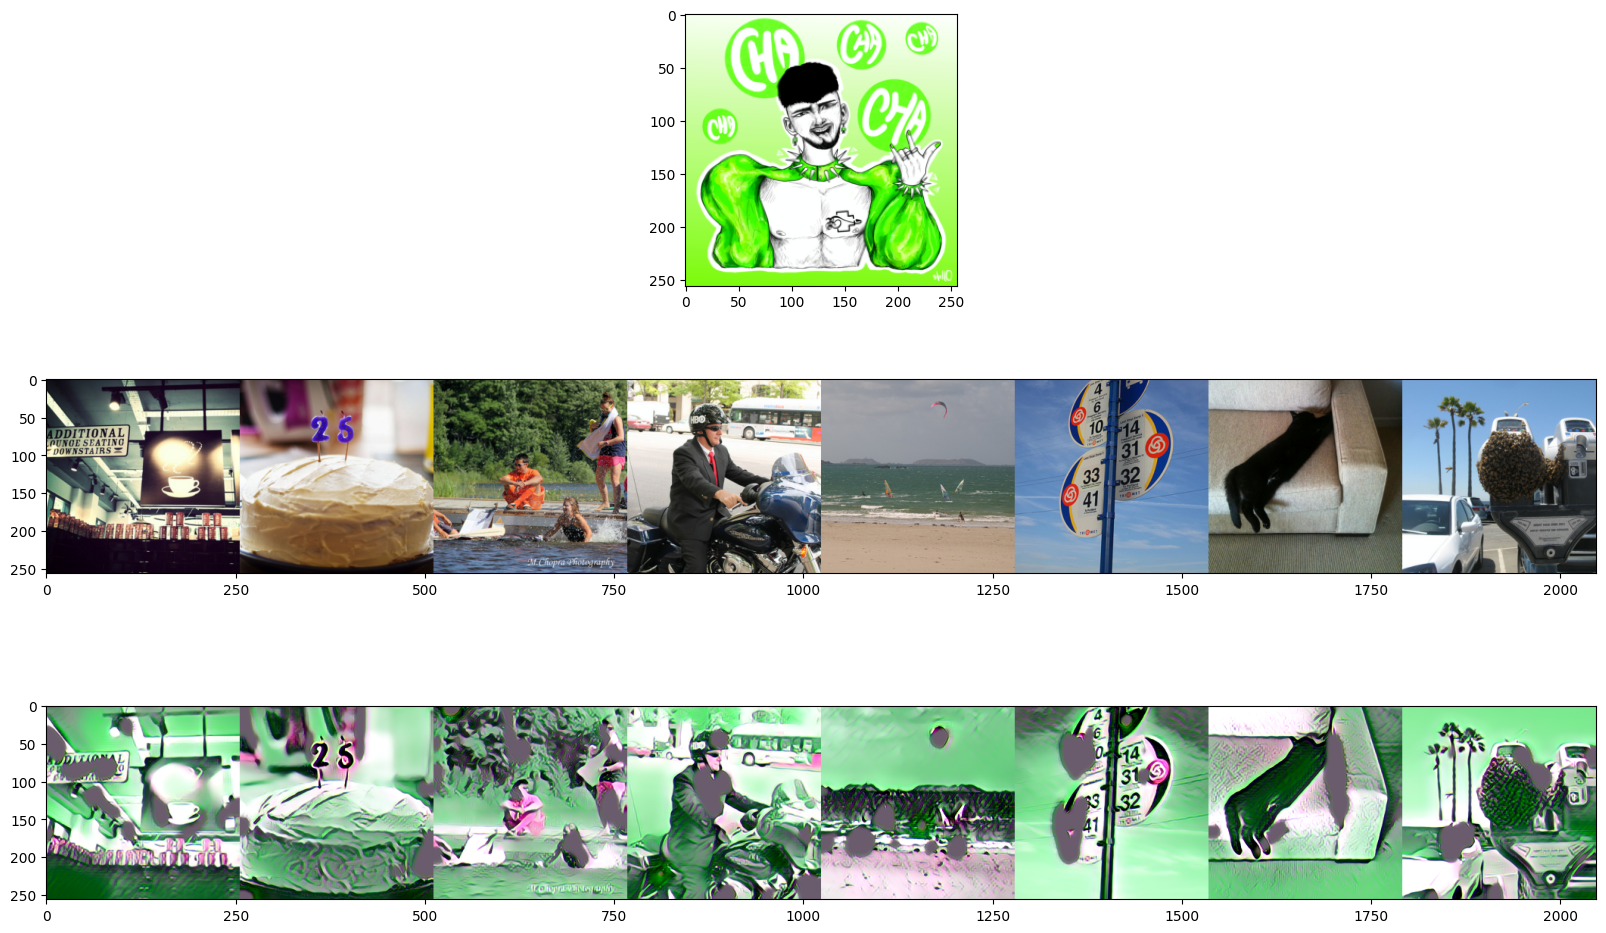

In [22]:
# selecting a few random images from our training content dataset
content_images = torch.stack([random.choice(content_dataset)[0] for i in range(4)]).to(device)

# selecting a random image from our style dataset
style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
style_features = vgg16(style_image)
style_mean_std = mean_std(style_features)

# creating a transformation network based on the selected style image
n_batch = 20
transform_net.reset_weights()
with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
    for batch, (content_images, _) in pbar:
        x = content_images.cpu().numpy()
        if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
            continue

        optimizer.zero_grad()

        weights = metanet.forward(mean_std(style_features))
        transform_net.set_weights(weights, 0)

        content_images = content_images.to(device)
        transformed_images = transform_net(content_images)

        content_features = vgg16(content_images)
        transformed_features = vgg16(transformed_images)
        transformed_mean_std = mean_std(transformed_features)

        content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])
        style_loss = style_weight * F.mse_loss(transformed_mean_std,
                                               style_mean_std.expand_as(transformed_mean_std))

        y = transformed_images
        tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        loss = content_loss + style_loss + tv_loss

        loss.backward()
        optimizer.step()

        if batch > n_batch:
            break

# performing neural style transfer
transformed_images = transform_net(content_images)

# processing images for visualization
transformed_images_vis = torch.cat([x for x in transformed_images], dim= -1)
content_images_vis = torch.cat([x for x in content_images], dim= -1)

# showcasing the results on screen
plt.figure(figsize=(20, 12))
plt.subplot(3, 1, 1)
imshow(style_image)
plt.subplot(3, 1, 2)
imshow(content_images_vis)
plt.subplot(3, 1, 3)
imshow(transformed_images_vis)

# Saving images to files

In [23]:
# defining the paths where we want to save the images
output_content_folder = "/content/gdrive/MyDrive/outputImages_content_train_2"
output_transferred_folder = "/content/gdrive/MyDrive/outputImages_transferred_train_2"

# creating the folders
os.makedirs(output_content_folder, exist_ok=True)
os.makedirs(output_transferred_folder, exist_ok=True)

# saving the processed content images
for index, tensor_image in enumerate(content_images):
    filename = os.path.join(output_content_folder, f"image_{index}.png")
    save_transformed_images(tensor_image, filename)
    print(f"Image saved as {filename}")

# saving the processed transferred images
for index, tensor_image in enumerate(transformed_images):
    filename = os.path.join(output_transferred_folder, f"image_{index}.png")
    save_transformed_images(tensor_image, filename)
    print(f"Image saved as {filename}")

Image saved as /content/gdrive/MyDrive/outputImages_content_train_2/image_0.png
Image saved as /content/gdrive/MyDrive/outputImages_content_train_2/image_1.png
Image saved as /content/gdrive/MyDrive/outputImages_content_train_2/image_2.png
Image saved as /content/gdrive/MyDrive/outputImages_content_train_2/image_3.png
Image saved as /content/gdrive/MyDrive/outputImages_content_train_2/image_4.png
Image saved as /content/gdrive/MyDrive/outputImages_content_train_2/image_5.png
Image saved as /content/gdrive/MyDrive/outputImages_content_train_2/image_6.png
Image saved as /content/gdrive/MyDrive/outputImages_content_train_2/image_7.png
Image saved as /content/gdrive/MyDrive/outputImages_transferred_train_2/image_0.png
Image saved as /content/gdrive/MyDrive/outputImages_transferred_train_2/image_1.png
Image saved as /content/gdrive/MyDrive/outputImages_transferred_train_2/image_2.png
Image saved as /content/gdrive/MyDrive/outputImages_transferred_train_2/image_3.png
Image saved as /content/

# Testing it out on the validation datasets

First we initialize our validation datasets, the same way we did the content ones:

In [24]:
content_dataset_val = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/content_dataset_val', transform=data_transform)
style_dataset_val = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/style_dataset_val', transform=data_transform_style)

content_data_loader_val = torch.utils.data.DataLoader(content_dataset_val, batch_size=batch_size, shuffle=True, num_workers=multiprocessing.cpu_count())

print(content_dataset_val)
print('-'*20)
print(style_dataset_val)

Dataset ImageFolder
    Number of datapoints: 100
    Root location: /content/gdrive/MyDrive/content_dataset_val
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.5333, 1), ratio=(1, 1), interpolation=bilinear, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
--------------------
Dataset ImageFolder
    Number of datapoints: 5
    Root location: /content/gdrive/MyDrive/style_dataset_val
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


21it [00:10,  2.07it/s]


(256, 256, 3)
(256, 1024, 3)
(256, 1024, 3)


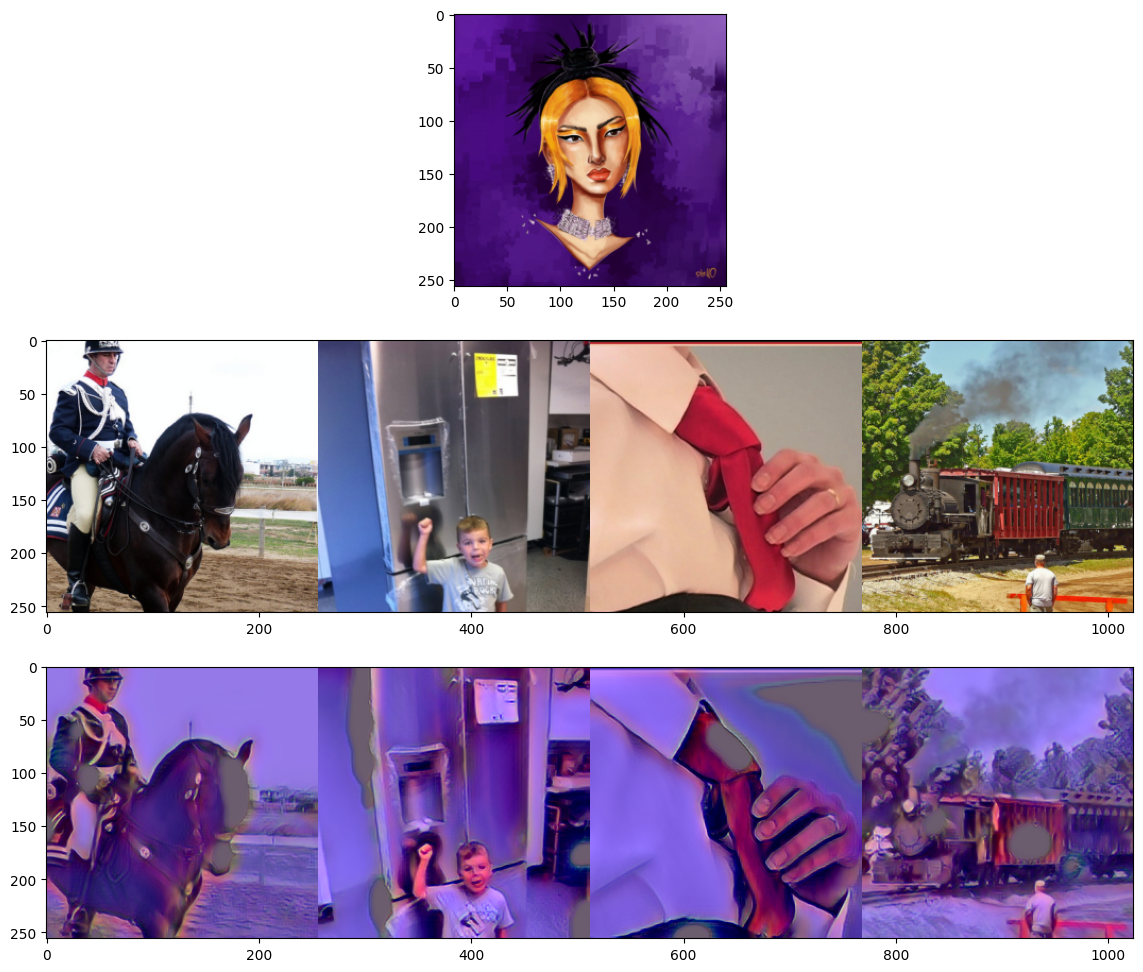

In [25]:
content_images_val = torch.stack([random.choice(content_dataset_val)[0] for i in range(4)]).to(device)

style_image = random.choice(style_dataset_val)[0].unsqueeze(0).to(device)
style_features = vgg16(style_image)
style_mean_std = mean_std(style_features)

# we reset the weights of the net
transform_net.reset_weights()

n_batch = 20
with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
    for batch, (content_images, _) in pbar:
        x = content_images.cpu().numpy()
        if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
            continue

        optimizer.zero_grad()
        weights = metanet.forward(mean_std(style_features))
        transform_net.set_weights(weights, 0)

        content_images = content_images.to(device)
        transformed_images = transform_net(content_images)

        content_features = vgg16(content_images)
        transformed_features = vgg16(transformed_images)
        transformed_mean_std = mean_std(transformed_features)

        content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])
        style_loss = style_weight * F.mse_loss(transformed_mean_std,
                                               style_mean_std.expand_as(transformed_mean_std))

        y = transformed_images
        tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        loss = content_loss + style_loss + tv_loss

        loss.backward()
        optimizer.step()

        if batch > n_batch:
            break

transformed_images_val = transform_net(content_images_val)
content_images_vis = torch.cat([x for x in content_images_val], dim=-1)
transformed_images_vis = torch.cat([x for x in transformed_images_val], dim=-1)

# showcasing the results on screen
plt.figure(figsize=(20, 12))
plt.subplot(3, 1, 1)
imshow(style_image)
plt.subplot(3, 1, 2)
imshow(content_images_vis)
plt.subplot(3, 1, 3)
imshow(transformed_images_vis)

# Saving images to files

In [26]:
# defining the paths where we want to save the images
output_content_folder_val = "/content/gdrive/MyDrive/outputImages_content_val_sketch2_2"
output_transferred_folder_val = "/content/gdrive/MyDrive/outputImages_transferred_val_sketch2_2"

# creating the folders
os.makedirs(output_content_folder_val, exist_ok=True)
os.makedirs(output_transferred_folder_val, exist_ok=True)

# saving the processed content images
for index, tensor_image in enumerate(content_images_val):
    filename = os.path.join(output_content_folder_val, f"image_{index}.png")
    save_transformed_images(tensor_image, filename)
    print(f"Image saved as {filename}")

# saving the processed transferred images
for index, tensor_image in enumerate(transformed_images_val):
    filename = os.path.join(output_transferred_folder_val, f"image_{index}.png")
    save_transformed_images(tensor_image, filename)
    print(f"Image saved as {filename}")

Image saved as /content/gdrive/MyDrive/outputImages_content_val_sketch2_2/image_0.png
Image saved as /content/gdrive/MyDrive/outputImages_content_val_sketch2_2/image_1.png
Image saved as /content/gdrive/MyDrive/outputImages_content_val_sketch2_2/image_2.png
Image saved as /content/gdrive/MyDrive/outputImages_content_val_sketch2_2/image_3.png
Image saved as /content/gdrive/MyDrive/outputImages_transferred_val_sketch2_2/image_0.png
Image saved as /content/gdrive/MyDrive/outputImages_transferred_val_sketch2_2/image_1.png
Image saved as /content/gdrive/MyDrive/outputImages_transferred_val_sketch2_2/image_2.png
Image saved as /content/gdrive/MyDrive/outputImages_transferred_val_sketch2_2/image_3.png
